In [6]:
# Parameters
input_filename = "./brain_tumor_dataset/yes/Y1.JPG"
output_filename = "Y1.JPG"

In [47]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [8]:
image = cv2.imread(input_filename)

In [9]:
def remove_boundaries(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_area_index = np.argmax(areas)
    largest_contour = contours[max_area_index]

    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

In [10]:
def scale(image):
    
    height = 600
    width = 600

    dim = (width, height)

    return cv2.resize(image, dim)

In [11]:
def remove_noise(image):
    return cv2.medianBlur(image, 5)

In [12]:
def sharpen_image(image):
    kernel_sharpening = np.array([[0,-1,0], 
                                  [-1, 5,-1],
                                  [0,-1,0]])
    return cv2.filter2D(image, -1, kernel_sharpening)

In [13]:
def apply_pipeline(image):

    boundary_less = remove_boundaries(image)
    scaled_image = scale(boundary_less)
    noiseless = remove_noise(scaled_image)
    sharpened = sharpen_image(noiseless)
    return sharpened

In [14]:
yes = []
no = []
all_images = []

yes_path = "./brain_tumor_dataset/yes/"
no_path = "./brain_tumor_dataset/no/"

In [15]:
temp_yes = []
temp_no = []

count = 0
for filename in os.listdir(yes_path):
    image = cv2.imread(yes_path + filename)
    temp_yes.append((image, 1))
    count += 1
    if count == 3:
        break

count = 0
for filename in os.listdir(no_path):
    image = cv2.imread(no_path + filename)
    temp_no.append((image, 0))
    count += 1
    if count == 3:
        break

temp_all = temp_yes + temp_no
data = [i[0] for i in temp_all]
labels = [i[1] for i in temp_all]

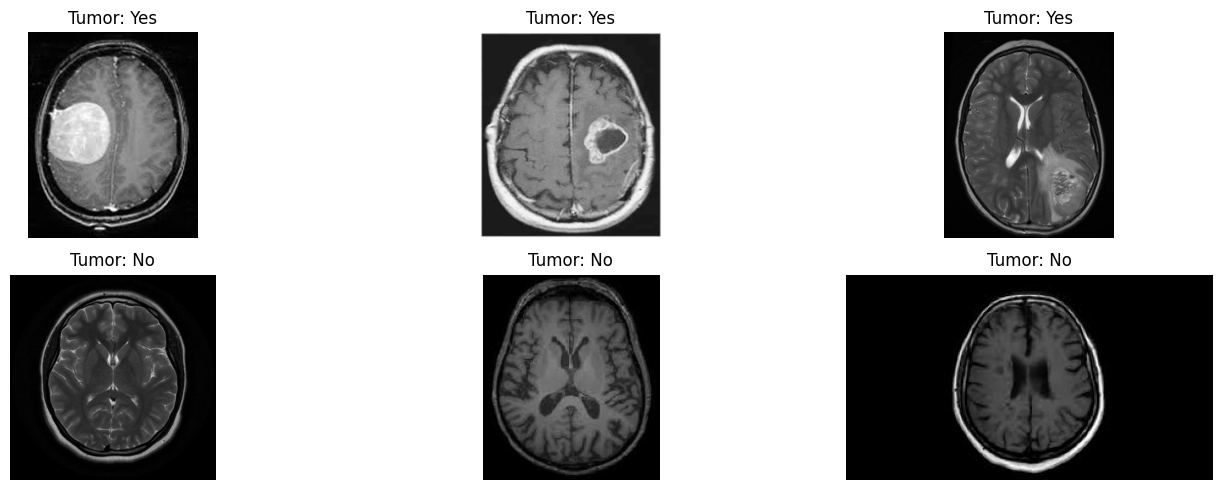

In [16]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(temp_yes[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(temp_no[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
temp_all = []
temp_image_path = "./brain_tumor_dataset/yes/Y1.jpg"
temp_image = cv2.imread(temp_image_path)
temp_all.append((temp_image, "Original Image"))

# Applying transformations
boundary_less = remove_boundaries(temp_image)
scaled_image = scale(boundary_less)
noiseless = remove_noise(scaled_image)
sharpened = sharpen_image(noiseless)

temp_all.append((boundary_less, "Boundary Less Image"))
temp_all.append((scaled_image, "Scaled Image"))
temp_all.append((noiseless, "Noiseless Image"))
temp_all.append((sharpened, "Shaprnened Image"))

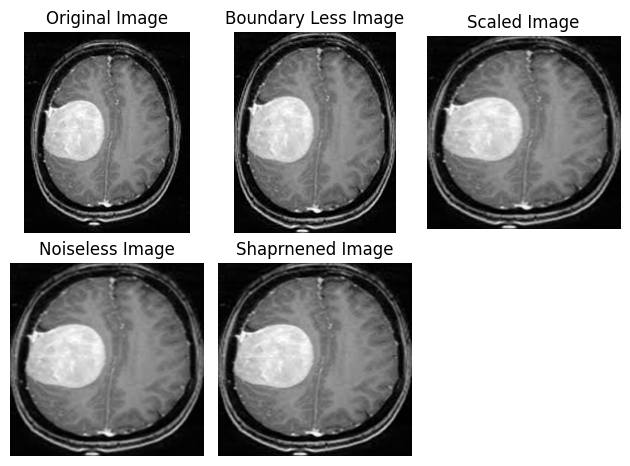

In [18]:
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(temp_all[i][0])  
    plt.title(temp_all[i][1])  
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Applying pre processing on Yes labelled images
for file_name in os.listdir(yes_path):
    img = cv2.imread(yes_path + file_name)
    yes.append((apply_pipeline(img), 1))

# Applying pre processing on No labelled images
for file_name in os.listdir(no_path):
    img = cv2.imread(no_path + file_name)
    no.append((apply_pipeline(img), 0))

all_images = yes + no

data = np.array([i[0] for i in all_images])
labels = np.array([i[1] for i in all_images])

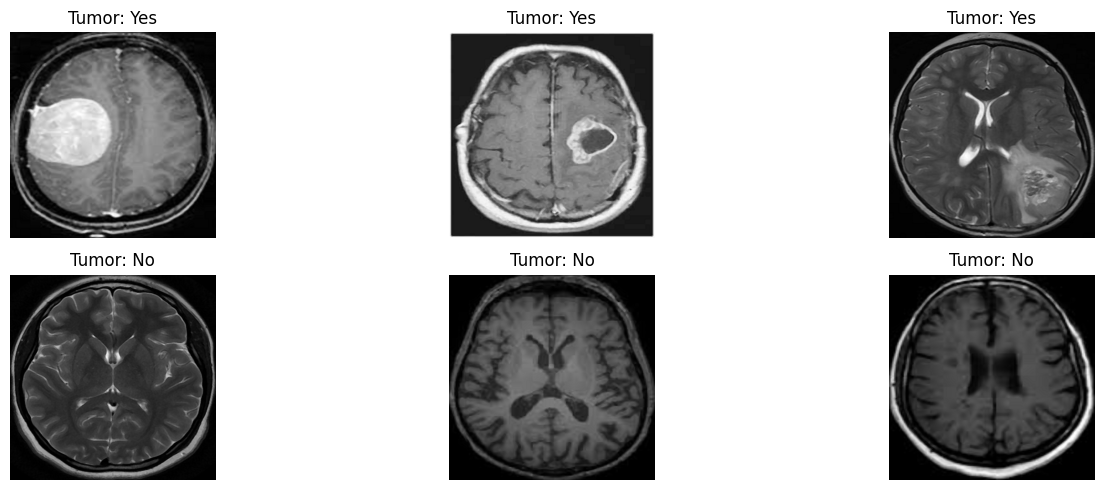

In [20]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(yes[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

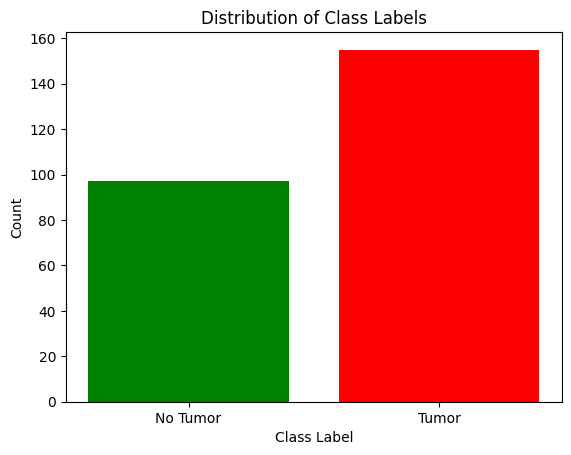

In [21]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['green', 'red'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [17]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(600, 600, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 598, 598, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 299, 299, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 297, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 148, 148, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 146, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 73, 73, 128)       0

In [22]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
test_data, val_images, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (201, 600, 600, 3)
Train labels shape: (201,)
Validation data shape: (26, 600, 600, 3)
Validation labels shape: (26,)
Test data shape: (25, 600, 600, 3)
Test labels shape: (25,)


In [23]:
print(np.max(train_data))
print(np.min(train_data))

train_images=train_data/255
test_images=test_data/255
val_images=val_images/255
print(np.max(train_images))
print(np.min(train_images))

255
0
1.0
0.0


In [58]:
epochs = 50 
batch_size = 16 

early_stopping = EarlyStopping(patience=5, monitor='val_loss')

history = model.fit(train_data, 
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                   callbacks=[early_stopping])

Epoch 1/50
13/13 [==============================] - 101s 7s/step - loss: 0.3308 - accuracy: 0.8458 - val_loss: 0.6904 - val_accuracy: 0.8846
Epoch 2/50
13/13 [==============================] - 94s 7s/step - loss: 0.2849 - accuracy: 0.8657 - val_loss: 0.6907 - val_accuracy: 0.7692
Epoch 3/50
13/13 [==============================] - 94s 7s/step - loss: 0.2113 - accuracy: 0.9154 - val_loss: 0.6898 - val_accuracy: 0.8846
Epoch 4/50
13/13 [==============================] - 93s 7s/step - loss: 0.1707 - accuracy: 0.9254 - val_loss: 0.6879 - val_accuracy: 0.8846
Epoch 5/50
13/13 [==============================] - 94s 7s/step - loss: 0.1341 - accuracy: 0.9552 - val_loss: 0.6874 - val_accuracy: 0.8846
Epoch 6/50
13/13 [==============================] - 93s 7s/step - loss: 0.1431 - accuracy: 0.9552 - val_loss: 0.6870 - val_accuracy: 0.9231
Epoch 7/50
13/13 [==============================] - 93s 7s/step - loss: 0.1318 - accuracy: 0.9502 - val_loss: 0.6860 - val_accuracy: 0.8077
Epoch 8/50
13/13 [=

In [59]:
model.save("./cnn.h5")

C:\Users\ibrah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model = load_model("./cnn.h5")



In [25]:
loss, accuracy = model.evaluate(test_images, test_labels)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1/1 [==============================] - 3s 3s/step - loss: 0.6878 - accuracy: 0.7200
Test Loss: 0.6877580285072327
Test Accuracy: 0.7200000286102295


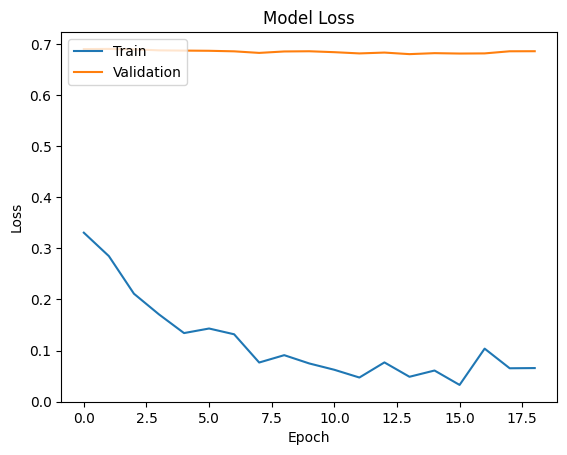

In [85]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 182ms/step


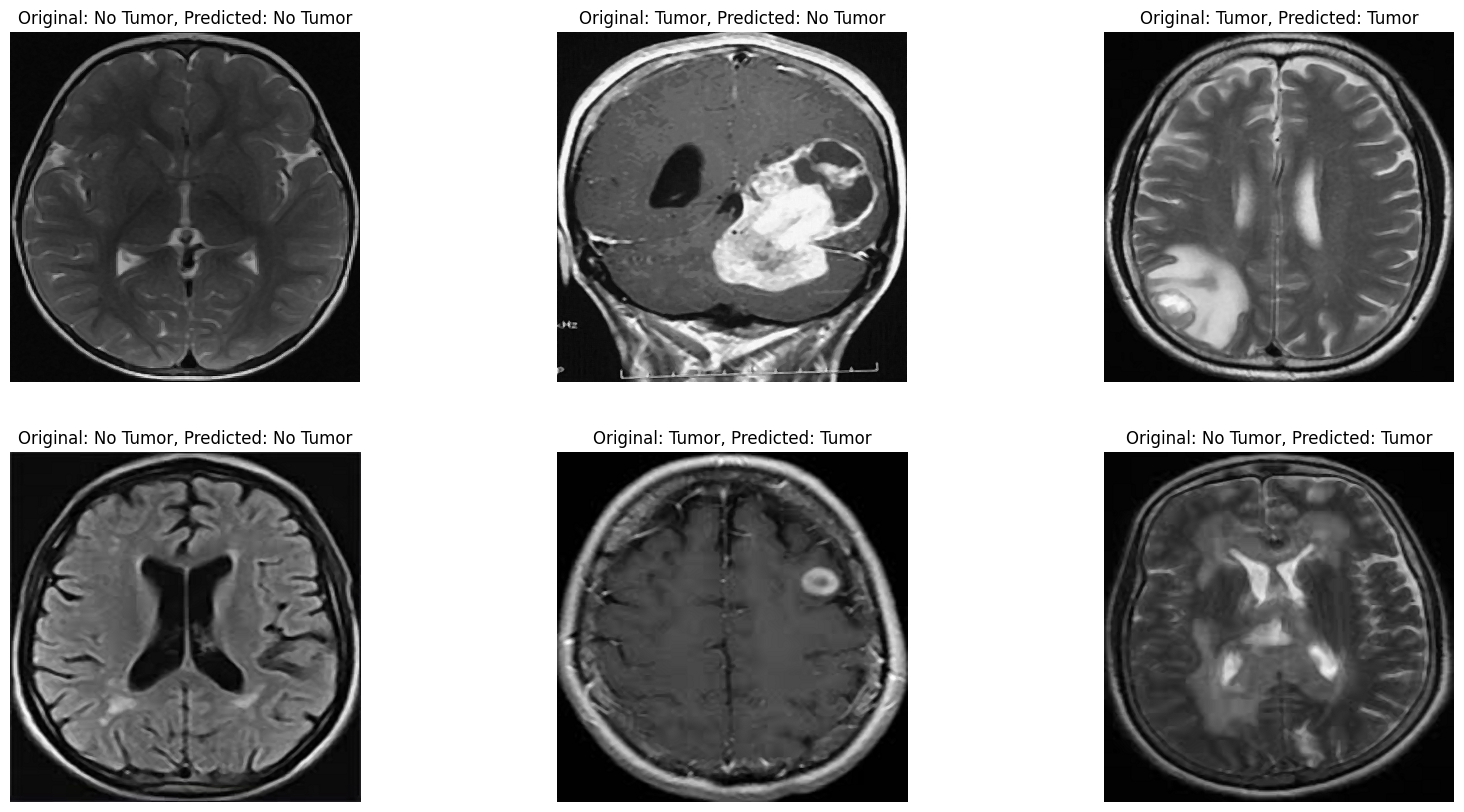

In [46]:
zipped = zip(test_data, test_labels)

count = 0
plt.figure(figsize=(20, 10))
for a, b in zipped:
    plt.subplot(2, 3, count + 1)
    plt.axis("off")
    org = "Tumor" if b == 1 else "No Tumor"
    pred = "Tumor" if model.predict(np.array([a/255]))[0][0] > 0.5 else "No Tumor"
    plt.title(f"Original: {org}, Predicted: {pred}")
    plt.imshow(a)
    if count == 5:
        break
    count += 1

plt.show()

1/1 [==============================] - 3s 3s/step
Accuracy on Validation Set: 0.808 %


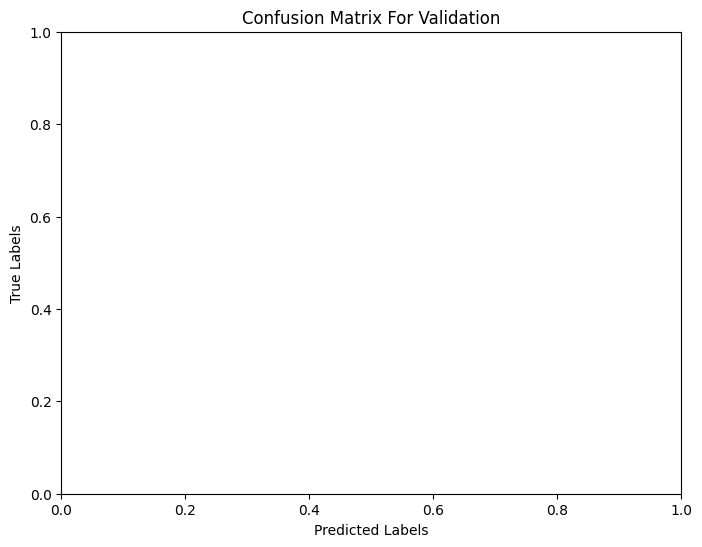